# # PART 1 - Exploring Data Analysis

In [33]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
from sklearn.model_selection import KFold

In [34]:
path = '../input/rsna-pneumonia-detection-challenge/' 
work_dir = '/kaggle/working'

In [35]:
# Loading datasets from kaggle challenge
class_info = pd.read_csv(path+'stage_2_detailed_class_info.csv')
train_labels = pd.read_csv(path+'stage_2_train_labels.csv')

In [36]:
# Checking datasets
class_info.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [37]:
# Checking datasets
train_labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [38]:
# Finding out nuber of rows and columns in dataset
print('Shape of class_info is',class_info.shape)
print('Shape of train_lables is',train_labels.shape)

Shape of class_info is (30227, 2)
Shape of train_lables is (30227, 6)


In [39]:
# Searching for Null values and finding datatypes of each features
class_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [40]:
# Searching for Null values and finding datatypes of each features
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


# Observation
train_labels have too many null values in features: 'x', 'y', 'width', 'height'.

In [41]:
train_labels.loc[train_labels['Target']==0]

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...
30216,c1cf3255-d734-4980-bfe0-967902ad7ed9,NaN,NaN,NaN,NaN,0
30217,c1e228e4-b7b4-432b-a735-36c48fdb806f,NaN,NaN,NaN,NaN,0
30218,c1e3eb82-c55a-471f-a57f-fe1a823469da,NaN,NaN,NaN,NaN,0
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0


# Observation:
All the values in fetures are null for those patients who have dignosed as not having pneumonia.

In [42]:
# Lets check unique values
class_info['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

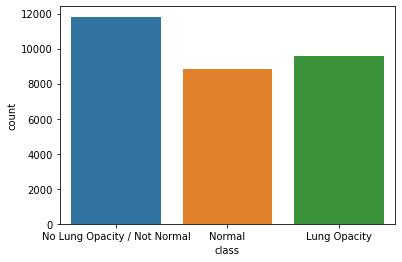

In [43]:
import seaborn as sns
sns.countplot(x='class', data=class_info)

In [44]:
# Merging train_labels and class_info on Patient ID

train_merged = train_labels.merge(class_info, left_on='patientId',right_on='patientId', how='inner')
train_merged=train_merged.drop_duplicates()
train_merged.reset_index(drop=True, inplace=True)
train_merged.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [45]:
#Let's see the relationship between image class and its target value
temporary = train_merged.groupby('Target')['class'].value_counts()
temporary

Target  class                       
0       No Lung Opacity / Not Normal    11821
        Normal                           8851
1       Lung Opacity                     9555
Name: class, dtype: int64

# **Observation**
> * All 9555 cases in class "lung opacity" are classifed under 
    'Target 1' i.e, all X-rays under class lung opacity, have pneumonia*

In [46]:
# Sorting the train and test images

import glob  # retrieve files/pathnames matching a specified pattern

train_img=sorted(glob.glob(path+'/stage_2_train_images/*'))
test_img=sorted(glob.glob(path+'/stage_2_test_images/*'))
print('No. of train images:',len(train_img))
print('First train image filename:',train_img[0])
print('No. of test images:',len(test_img))
print('First 5 test image name:',test_img[0])

No. of train images: 26684
First train image filename: ../input/rsna-pneumonia-detection-challenge//stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm
No. of test images: 3000
First 5 test image name: ../input/rsna-pneumonia-detection-challenge//stage_2_test_images/0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm


In [47]:
dcm_data = pydicom.dcmread(train_img[0])
dcm_data

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [48]:
# Viewing Sample images

im = dcm_data.pixel_array
plt.set_cmap('gray')
print(type(im))
print(im.dtype)

<class 'numpy.ndarray'>
uint8


<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'ID: 0004cfab-14fd-4e49-80ba-63a80b6bddd6\nAge: 51 Sex: F')

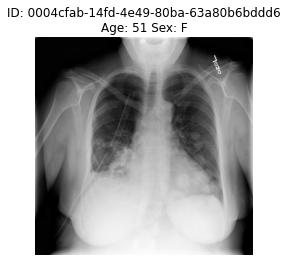

In [49]:
ax=plt.gca()
pid=dcm_data.PatientID
age = dcm_data.PatientAge
sex = dcm_data.PatientSex
plt.imshow(im)
plt.axis("off")
ax.set_title('ID: {}\nAge: {} Sex: {}'.format(pid,age, sex))

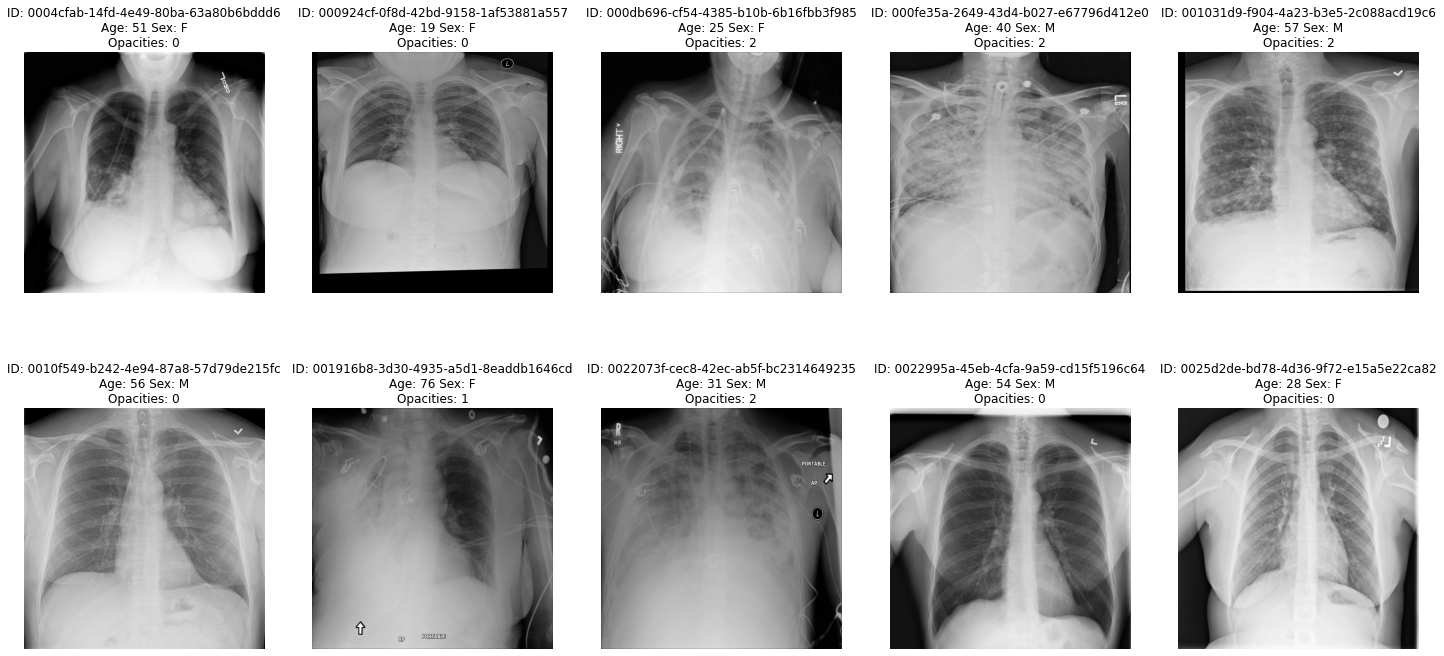

In [50]:
fig=plt.figure(figsize=(25, 12))
for i in range(0,10):
    dcm_data = pydicom.dcmread(train_img[i])
    im=dcm_data.pixel_array    
    fig.add_subplot(2, 5, i+1)
    ax=plt.gca()
    stat=train_merged[train_merged.patientId==dcm_data.PatientID]["Target"].sum()
    pid=dcm_data.PatientID
    age = dcm_data.PatientAge
    sex = dcm_data.PatientSex
    plt.imshow(im)
    plt.axis("off")
    ax.set_title('ID: {}\nAge: {} Sex: {}\nOpacities: {}'.format(pid,age,sex,stat))

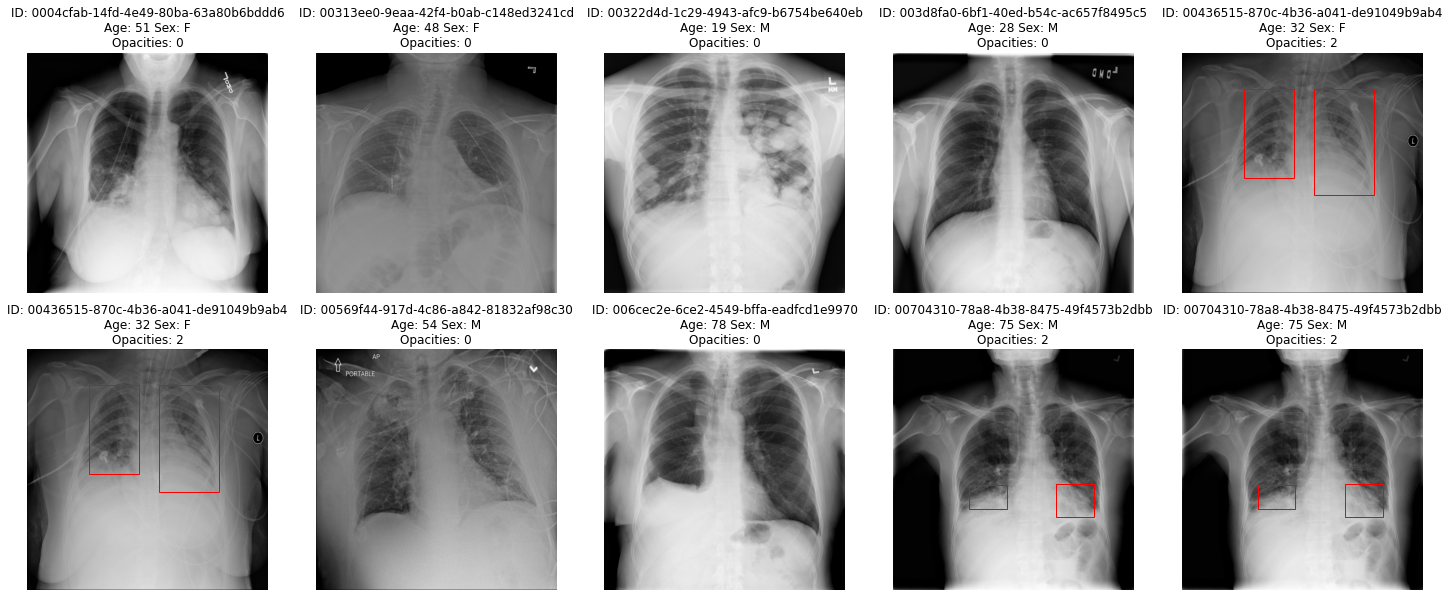

In [51]:
fig=plt.figure(figsize=(25, 10))
for i in range(10):
    patientId = train_labels['patientId'][i]
    train_img=path+'/stage_2_train_images/%s.dcm'%patientId
    dcm_data = pydicom.dcmread(train_img)
    im=dcm_data.pixel_array
    fig.add_subplot(2, 5, i+1)
    plt.imshow(im)
    plt.axis("off")
    ax = plt.gca()
    df_temp=train_labels[train_labels['patientId'] == patientId]
    for index, row in df_temp.iterrows():
        rect = plt.Rectangle((row['x'], row['y']), row['width'], row['height'], color='red',fill=False)
        ax.add_patch(rect)
    stat=train_merged[train_merged.patientId==dcm_data.PatientID]["Target"].sum()
    pid=dcm_data.PatientID
    age = dcm_data.PatientAge
    sex = dcm_data.PatientSex
    plt.imshow(im)
    plt.axis("off")
    ax.set_title('ID: {}\nAge: {} Sex: {}\nOpacities: {}'.format(pid,age,sex,stat))

# PART 2- Building a model

In [52]:
train_labels_train = train_merged.sample(frac=1).reset_index(drop=True)
train_labels_train=train_labels_train.drop_duplicates()

In [53]:
train_labels_train

,patientId,x,y,width,height,Target,class
0,41b00808-a610-492c-b2f5-82de09d84366,534.0,285.0,219.0,516.0,1,Lung Opacity
1,366c5768-5fba-4ba1-8532-082d3ba3c9bf,227.0,577.0,176.0,169.0,1,Lung Opacity
2,080f2b35-fcd5-473e-864b-a7dea3054cc7,278.0,228.0,238.0,403.0,1,Lung Opacity
3,e199c5fb-1418-4803-b274-c2890ec14030,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
4,2230de59-e044-4b6d-95c0-1154c0cbb802,642.0,521.0,120.0,255.0,1,Lung Opacity
...,...,...,...,...,...,...,...
30222,aca5cb44-9cfc-420b-a0c4-19f9ef692afb,571.0,451.0,204.0,217.0,1,Lung Opacity
30223,5f6f8f25-1b29-43da-9ac8-01970feb489c,NaN,NaN,NaN,NaN,0,Normal
30224,354298de-cfa4-435c-b757-4dbce12102d6,NaN,NaN,NaN,NaN,0,Normal
30225,d084e093-1b8c-4478-811e-f1d337cbeb2c,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal


In [54]:
df_t0_t=train_labels_train[train_labels_train['Target'] == 0]
df_t1_t=train_labels_train[train_labels_train['Target'] == 1]
df_t1_t.reset_index(drop=True, inplace=True)
df_t0_t.reset_index(drop=True, inplace=True)
df_t0_v = pd.DataFrame(columns=df_t0_t.columns)
df_t1_v= pd.DataFrame(columns=df_t1_t.columns)

In [55]:
df_t0_t

,patientId,x,y,width,height,Target,class
0,e199c5fb-1418-4803-b274-c2890ec14030,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,5ed0a141-2878-44e3-983b-bc51928f7e65,NaN,NaN,NaN,NaN,0,Normal
2,b180c8c3-adad-4d7c-aa3e-1e352f95bee8,NaN,NaN,NaN,NaN,0,Normal
3,ffe16061-b19f-4333-8a03-b41aab42b47d,NaN,NaN,NaN,NaN,0,Normal
4,a7ca6a31-966b-4b60-9a87-4687c814e937,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
...,...,...,...,...,...,...,...
20667,d32664da-313a-45dc-90f7-0759ac76e207,NaN,NaN,NaN,NaN,0,Normal
20668,5f6f8f25-1b29-43da-9ac8-01970feb489c,NaN,NaN,NaN,NaN,0,Normal
20669,354298de-cfa4-435c-b757-4dbce12102d6,NaN,NaN,NaN,NaN,0,Normal
20670,d084e093-1b8c-4478-811e-f1d337cbeb2c,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal


In [56]:
df_t1_t

,patientId,x,y,width,height,Target,class
0,41b00808-a610-492c-b2f5-82de09d84366,534.0,285.0,219.0,516.0,1,Lung Opacity
1,366c5768-5fba-4ba1-8532-082d3ba3c9bf,227.0,577.0,176.0,169.0,1,Lung Opacity
2,080f2b35-fcd5-473e-864b-a7dea3054cc7,278.0,228.0,238.0,403.0,1,Lung Opacity
3,2230de59-e044-4b6d-95c0-1154c0cbb802,642.0,521.0,120.0,255.0,1,Lung Opacity
4,7a1e02f8-4965-4364-918b-83d3422f931b,632.0,489.0,144.0,260.0,1,Lung Opacity
...,...,...,...,...,...,...,...
9550,796c9a6a-2ea4-4361-93ec-bfa894d4033e,522.0,331.0,238.0,403.0,1,Lung Opacity
9551,193d589c-8295-4445-8e13-bd3beeddcbe4,93.0,204.0,372.0,645.0,1,Lung Opacity
9552,b8020472-9c2d-44ce-a09b-f5795b95f230,591.0,626.0,262.0,225.0,1,Lung Opacity
9553,3d7fb4b4-5e62-4591-aa4d-cbbc1ca3ffb7,598.0,519.0,278.0,324.0,1,Lung Opacity


In [57]:
temp1=df_t0_t[df_t0_t['class'] == 'Normal']
temp2=df_t0_t[df_t0_t['class'] == 'No Lung Opacity / Not Normal']
rows1 = temp1.loc[:1000]
rows2 = temp2.loc[:1000]
df_t0_v=df_t0_v.append(rows1, ignore_index=True)
df_t0_v=df_t0_v.append(rows2, ignore_index=True)
df_t0_t.drop(rows1.index, inplace=True)
df_t0_t.drop(rows2.index, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [58]:
df_t0_t.reset_index(drop=True, inplace=True)

In [59]:
rows1 = df_t1_t.loc[:500]
df_t1_v=df_t1_v.append(rows1, ignore_index=True)
df_t1_t.drop(rows1.index, inplace=True)
df_t1_t.reset_index(drop=True, inplace=True)

In [60]:
df_t1_t = df_t1_t.sample(frac=1).reset_index(drop=True)
df_t1_v = df_t1_v.sample(frac=1).reset_index(drop=True)
df_t0_t = df_t0_t.sample(frac=1).reset_index(drop=True)
df_t0_v = df_t0_v.sample(frac=1).reset_index(drop=True)

In [61]:
folders = ['train','test','validation']
for folder in folders:
    if not os.path.isdir(os.path.join(work_dir, folder)):
        os.mkdir(os.path.join(work_dir, folder))

In [62]:
train_path=work_dir+"/train"
folders = ['not pneumonia' ,'pneumonia']
for folder in folders:
    if not os.path.isdir(os.path.join(train_path, folder)):
        os.mkdir(os.path.join(train_path, folder))

In [63]:
valid_path=work_dir+"/validation"
folders = ['not pneumonia' ,'pneumonia']
for folder in folders:
    if not os.path.isdir(os.path.join(valid_path, folder)):
        os.mkdir(os.path.join(valid_path, folder))

In [64]:
inputdir = path+'/stage_2_train_images/'
outdir=train_path+'/not pneumonia/'
for row in range(len(df_t0_t)):
    pid=df_t0_t['patientId'][row]
    ds = pydicom.read_file(inputdir + '%s.dcm'%pid) # read dicom image
    img = ds.pixel_array
    cv2.imwrite(outdir + '%s.png'%pid,img)

In [65]:
outdir=train_path+'/pneumonia/'
for row in range(len(df_t1_t)):
    pid=df_t1_t['patientId'][row]
    ds = pydicom.read_file(inputdir + '%s.dcm'%pid) # read dicom image
    img = ds.pixel_array
    cv2.imwrite(outdir + '%s.png'%pid,img)

In [66]:
outdir=valid_path+'/not pneumonia/'
for row in range(len(df_t0_v)):
    pid=df_t0_v['patientId'][row]
    ds = pydicom.read_file(inputdir + '%s.dcm'%pid) # read dicom image
    img = ds.pixel_array
    cv2.imwrite(outdir + '%s.png'%pid,img)

In [67]:
outdir=valid_path+'/pneumonia/'
for row in range(len(df_t1_v)):
    pid=df_t1_v['patientId'][row]
    ds = pydicom.read_file(inputdir + '%s.dcm'%pid) # read dicom image
    img = ds.pixel_array
    cv2.imwrite(outdir + '%s.png'%pid,img)

In [68]:
test_path=work_dir+"/test/"
test_img=sorted(glob.glob(path+'stage_2_test_images/*'))
for row in range(len(test_img)):
    ds = pydicom.read_file(test_img[row]) # read dicom image
    img = ds.pixel_array
    backtorgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    cv2.imwrite(test_path + '%s.png'%ds.PatientID,backtorgb)

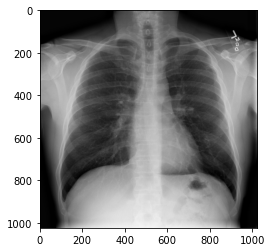

In [69]:
t_img=glob.glob(test_path+'*')
import matplotlib.image as mpimg

im = mpimg.imread(t_img[0])
plt.imshow(im) 
plt.show()

In [70]:
len(os.listdir(train_path+'/not pneumonia'))

19725

In [71]:
len(os.listdir(train_path+'/pneumonia'))

5866

In [72]:
len(os.listdir(valid_path+'/not pneumonia'))

1001

In [73]:
len(os.listdir(valid_path+'/pneumonia'))

491

len(os.listdir(test_path))

import matplotlib.image as mpimg

img = mpimg.imread('/kaggle/working/train/non_pneumonia/4bf4ff92-3ecf-455c-b405-ebea5211344f.png')
plt.imshow(img)
plt.show()

In [74]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from PIL import ImageDraw, ImageFont,Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_generator = ImageDataGenerator(rescale = 1./255,preprocessing_function=preprocess_input,
                                             horizontal_flip = True,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.2,
                                             shear_range = 0.2,
                                             zoom_range = 0.2)
train_gen = image_generator.flow_from_directory(batch_size = 1,
                                                      directory= train_path, 
                                                      shuffle = True, 
                                                      target_size = (224, 224),
                                                      color_mode="rgb",
                                                      class_mode = 'categorical',
                                                      subset= 'training',
                                                      seed = 0)
validation_gen = image_generator.flow_from_directory(batch_size = 1, 
                                                      directory= valid_path, 
                                                      shuffle = True,
                                                     color_mode="rgb",
                                                      target_size = (224, 224),
                                                      class_mode = 'categorical',
                                                      seed = 0)

Found 25591 images belonging to 2 classes.
Found 1492 images belonging to 2 classes.


In [75]:
train_gen.filepaths[0]

'/kaggle/working/train/not pneumonia/0004cfab-14fd-4e49-80ba-63a80b6bddd6.png'

In [76]:
validation_gen.image_shape

(224, 224, 3)

In [77]:
train_gen.filenames[0]

'not pneumonia/0004cfab-14fd-4e49-80ba-63a80b6bddd6.png'

In [78]:
train_gen._filepaths[200][36:72]

'060c4f8a-f04f-4f46-88fc-3d0b90f3608c'

train_labels_gen=pd.DataFrame()
for i in range(len(train_gen)):
    train_labels_gen=train_labels_gen.append(train_labels_train[train_labels_train['patientId'] == train_gen._filepaths[i][36:72] & train_labels_train['patientId'] == train_gen._filepaths[i][32:68]])

valid_labels_gen=pd.DataFrame()
for i in range(len(validation_gen)):
    valid_labels_gen=valid_labels_gen.append(train_labels_train[train_labels_train['patientId'] == validation_gen._filepaths[i][36:72]])

train_labels_gen

In [79]:
from tensorflow.python.keras.models import Sequential, Model
from keras import optimizers
import tensorflow as tf
from keras import layers
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D,Input,Dropout,BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
basemodel = ResNet50(include_top=False,input_tensor=Input(shape=(224, 224, 3)))
for layer in basemodel.layers:
    layer.trainable=False
result = GlobalAveragePooling2D()(basemodel.output)
# add a fully-connected layer
result = Dense(512, activation='relu')(result)
predictions = Dense(2, activation='sigmoid')(result)

94773248/94765736 [==============================] - 2s 0us/step


In [80]:
model = Model(inputs=basemodel.input, outputs=predictions)

In [81]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [82]:
model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=["accuracy"])

In [83]:
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [84]:
model.fit_generator(
    train_gen, steps_per_epoch=len(train_gen)/18,shuffle = True,
    epochs=20, validation_data = validation_gen,validation_steps=len(validation_gen)/18, callbacks=[mc])

Epoch 1/20
1422/1421 [==============================] - ETA: 0s - loss: 0.5840 - accuracy: 0.7616
Epoch 00001: val_accuracy improved from -inf to 0.65060, saving model to best_model.h5
1422/1421 [==============================] - 171s 120ms/step - loss: 0.5840 - accuracy: 0.7616 - val_loss: 0.6613 - val_accuracy: 0.6506
Epoch 2/20
1422/1421 [==============================] - ETA: 0s - loss: 0.5557 - accuracy: 0.7595
Epoch 00002: val_accuracy did not improve from 0.65060
1422/1421 [==============================] - 169s 119ms/step - loss: 0.5557 - accuracy: 0.7595 - val_loss: 0.7043 - val_accuracy: 0.6386
Epoch 3/20
1422/1421 [==============================] - ETA: 0s - loss: 0.5094 - accuracy: 0.7947
Epoch 00003: val_accuracy improved from 0.65060 to 0.66265, saving model to best_model.h5
1422/1421 [==============================] - 169s 119ms/step - loss: 0.5094 - accuracy: 0.7947 - val_loss: 0.6833 - val_accuracy: 0.6627
Epoch 4/20
1422/1421 [==============================] - ETA: 0s

In [85]:
from keras.models import load_model
saved_model=load_model('best_model.h5')

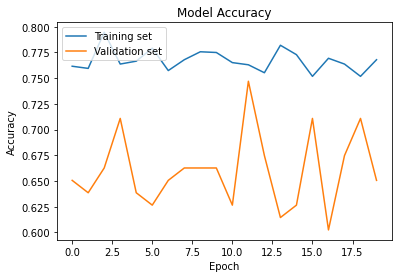

In [86]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

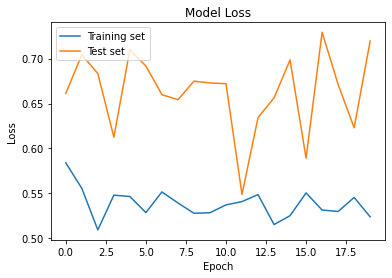

In [87]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()

In [88]:
predictions = saved_model.predict_generator(validation_gen, steps=len(validation_gen),verbose = True)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

1492/1492 [==============================] - 164s 110ms/step


In [89]:
predictions[:100]

array([[0.8247797 , 0.27543017],
       [0.7750881 , 0.3174685 ],
       [0.77449197, 0.31794786],
       [0.7833964 , 0.3107333 ],
       [0.7802266 , 0.3133152 ],
       [0.86765695, 0.23474783],
       [0.8472528 , 0.254741  ],
       [0.8765511 , 0.22560018],
       [0.77080697, 0.32089958],
       [0.7959732 , 0.30033183],
       [0.78947794, 0.3057359 ],
       [0.7827825 , 0.31123456],
       [0.77450097, 0.31794065],
       [0.845819  , 0.25609955],
       [0.8094163 , 0.288912  ],
       [0.81853807, 0.28096652],
       [0.8089665 , 0.28929943],
       [0.8419698 , 0.2597192 ],
       [0.79432523, 0.30170965],
       [0.8036455 , 0.29385465],
       [0.8641625 , 0.23826534],
       [0.7711344 , 0.32063815],
       [0.817266  , 0.28208464],
       [0.8144555 , 0.28454325],
       [0.86557496, 0.2368485 ],
       [0.7829616 , 0.31108838],
       [0.78144646, 0.3123234 ],
       [0.9079683 , 0.19058582],
       [0.8276093 , 0.27289218],
       [0.81069714, 0.28780624],
       [0.

In [90]:
import sklearn.metrics as metrics
true_classes = validation_gen.classes
class_labels = list(validation_gen.class_indices.keys())   
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

               precision    recall  f1-score   support

not pneumonia       0.67      1.00      0.80      1001
    pneumonia       0.00      0.00      0.00       491

     accuracy                           0.67      1492
    macro avg       0.34      0.50      0.40      1492
 weighted avg       0.45      0.67      0.54      1492



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
submission=pd.DataFrame(columns=['patientId','Prediction String'])
np.set_printoptions(precision=5)
for i in range(len(t_img)):
    im = mpimg.imread(t_img[i])
    image = cv2.resize(im, (224, 224))
    feat_scaled = preprocess_input(np.array(image, dtype=np.float32))
    prediction=model.predict(x=np.array([feat_scaled]))
    predicted_classes = np.argmax(prediction, axis=1)
    listToStr = ' '.join([str(elem) for elem in prediction]) 
    submission=submission.append({'patientId': t_img[i][21:57],'Prediction String':listToStr}, ignore_index=True) 

In [92]:
submission

,patientId,Prediction String
0,279433ff-5347-417b-ab70-51f06e227130,[0.97937 0.02829]
1,1b8d026f-3989-4cd6-a4c7-4ed8fb8887d0,[0.97617 0.03278]
2,138273ef-6107-48a6-ac8c-dd71a725b45b,[0.97941 0.02859]
3,c107a573-4b0f-4b31-9ad5-f33279364ff3,[0.97542 0.03327]
4,12f50cdb-7dca-4ef1-9f75-d36c540ea830,[0.97933 0.02825]
...,...,...
2995,1a37de22-589c-4773-b97d-8334a2d674c4,[0.9783 0.02917]
2996,1a4926e2-9d99-426e-a799-c8002ef2ca79,[0.98298 0.0232 ]
2997,c08fe556-bde0-4c18-bf5c-32231f92abac,[0.98257 0.0243 ]
2998,01708093-89aa-40aa-a121-4c8011fd0016,[0.97559 0.03374]


In [93]:
submission.to_csv('submission.csv',index=False)